# Visualisations

This notebooks shows how to visualise the predictions of the semantic and panotpic segmentation models similarly to the figures presented in the paper.
In particular, we reproduce Figure 5 comparing the semantic prediction of U-TAE to the panoptic prediction of U-TAE+PaPs on the same Sentinel-2 Patch. 

### Requirements:
- PASTIS dataset
- Pre-trained weights of the models
- opencv-python (in addition tothe other requirements of the repository) 

Fill-in the paths in the next cell, and execute the cells to obtain the visualisation. 

In [1]:
### FILL THESE VALUES ###

PATH_TO_REPO = './'
PATH_TO_DATA = '/home/fourier/paulo/datasets/PASTIS-R'
PATH_TO_WEIGHTS = '/home/fourier/paulo/biomass/Exchanger4SITS/output/run02/PASTIS-R/pastis_semseg_exchanger_unet_Fold0/Fold_0/checkpoint.pth.tar'
PATH_TO_CONFIG = '/home/fourier/paulo/biomass/Exchanger4SITS/configs/pastis/finetune/pastis_semseg_exchanger_unet_Fold0.yml'
device = 'cpu' # or "cpu"

#######

import torch

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from matplotlib import patches
import numpy as np
import sys
sys.path.append(PATH_TO_REPO) 

from datasets.pastis import PASTISReader
from utils import pad_collate

from models.sem_seg import Segmentor
from config import config, update_config

import cv2

import warnings
warnings.filterwarnings('ignore')


# Colormap (same as in the paper)
cm = plt.get_cmap('tab20')
def_colors = cm.colors
cus_colors = ['k'] + [def_colors[i] for i in range(1,19)]+['w']
cmap = ListedColormap(colors = cus_colors, name='agri',N=20)

label_names = [
"Background",
"Meadow",
"Soft winter wheat",
"Corn",
"Winter barley",
"Winter rapeseed",
"Spring barley",
"Sunflower",
"Grapevine",
"Beet",
 "Winter triticale",
 "Winter durum wheat",
 "Fruits,  vegetables, flowers",
 "Potatoes",
 "Leguminous fodder",
 "Soybeans",
 "Orchard",
 "Mixed cereal",
 "Sorghum",
 "Void label"]

/home/fourier/paulo/biomass/Exchanger4SITS/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class HelperConfig():
    def __init__(self, cfg, opts = []):
        self.cfg = cfg
        self.opts = opts

update_config(config, HelperConfig(PATH_TO_CONFIG))

In [4]:
# Utilities

def load_model(path, device):
    """Load pre-trained model"""
    model = Segmentor(config, mode="eval").to(device)
    sd = torch.load(path, map_location=device)
    model.load_state_dict(sd['state_dict'])
    model.eval()
    return model


def get_rgb(x, b=0, t_show=6):
    """Gets an observation from a time series and normalises it for visualisation."""
    im = x[b, t_show, [2, 1, 0]].cpu().numpy()
    mx = im.max(axis=(1, 2))
    mi = im.min(axis=(1, 2))
    im = (im - mi[:, None, None])/(mx - mi)[:, None, None]
    im = im.swapaxes(0, 2).swapaxes(0, 1)
    im = np.clip(im, a_max=1, a_min=0)
    return im
    # ground_truth_instances = gt[batch_element, :, :, 1].cpu().numpy()
    grount_truth_semantic = gt[batch_element, :, :].cpu().numpy()

    for inst_id in np.unique(grount_truth_semantic):
        if inst_id == 0:
            continue
        mask = (grount_truth_semantic == inst_id)
        try:
            c, h = cv2.findContours(mask.astype(
                int), cv2.RETR_FLOODFILL, cv2.CHAIN_APPROX_SIMPLE)
            u, cnt = np.unique(grount_truth_semantic[mask], return_counts=True)
            cl = u if np.isscalar(u) else u[np.argmax(cnt)]

            if cl == 19 and not plot_void:  # Not showing predictions for Void objects
                continue

            color = cmap.colors[int(cl)]
            for co in c[1::2]:
                poly = patches.Polygon(
                    co[:, 0, :], fill=True, alpha=alpha, linewidth=0, color=color)
                ax.add_patch(poly)
                poly = patches.Polygon(
                    co[:, 0, :], fill=False, alpha=.8, linewidth=4, color=color)
                ax.add_patch(poly)
        except ValueError as e:
            print(e)

In [6]:
# Load dataset and models

n_fold = config.DATASET.N_FOLD
fold_sequence = [
    [[1, 2, 3], [4], [5]],
    [[2, 3, 4], [5], [1]],
    [[3, 4, 5], [1], [2]],
    [[4, 5, 1], [2], [3]],
    [[5, 1, 2], [3], [4]],
]
_, val_fold, _ = fold_sequence[n_fold]

batch_size = config.TRAIN.BATCH_SIZE_PER_GPU
dt = PASTISReader(config, nfolds=val_fold, mode='test')
dl = torch.utils.data.DataLoader(
    dt, batch_size=batch_size, shuffle=True, collate_fn=pad_collate)
iterator = dl.__iter__()
device = torch.device(device)


# semseg = load_model(PATH_TO_WEIGHTS, device=device).eval()

In [8]:
# Inference on one batch
from utils import recursive2device

batch = recursive2device(iterator.__next__(), device)
modality = config.DATASET.MODALITY[0]
ignore_index = -1

with torch.no_grad():
    x = batch[f'data_{modality}'][:, :-1, ...].float()
    labels = batch['label'][:, 0, ...].long() # [B, H, W]
    spatial_pad_masks = batch['label'][:, -1, ...].bool()
    y = labels.masked_fill(spatial_pad_masks, ignore_index)

    # outputs = semseg(batch)[0]
    # preds = outputs['preds'] # [b, c, h, w] or [b, h, w]
    # sempred = preds.softmax(dim=1).argmax(dim=1)

In [31]:
batch['field_id']
np.load('/home/fourier/paulo/datasets/PASTIS-R/ANNOTATIONS/ParcelIDs_10539.npy').shape

(128, 128)

[ 0  1  2  3  4 10 12 14 17 19]


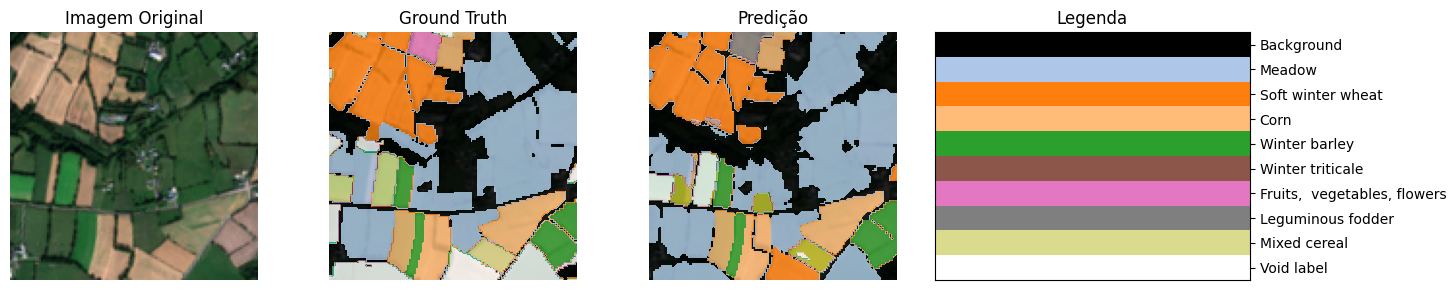

In [329]:
b = 0
img = x.permute(0,2,1,3,4)
img = get_rgb(img, b, t_show=2)
label = y[b].cpu().numpy()
pred = sempred[b].cpu().numpy()

fig, axs = plt.subplots(ncols=4, figsize=(15, 3))

titles = ["Imagem Original", "Ground Truth", "Predição"]
images = [img, label, pred]

label[label == -1] = 19
labels = np.unique(np.append(np.unique(pred), np.unique(label)))
print(labels)

for ax, title, im in zip(axs, titles, images):
    ax.imshow(img, cmap=cmap)
    ax.imshow(im, cmap=cmap, alpha=0.4)
    ax.axis('off')
    ax.set_title(title)


axs[3].set_title("Legenda")
axs[3].matshow(np.stack([labels for _ in range(3)], axis=1), cmap = cmap, aspect='auto')
axs[3].set_yticks(ticks = range(len(labels)), labels=[label_names[i] for i in labels])
axs[3].set_xticks(ticks=[])
axs[3].yaxis.tick_right()

plt.tight_layout()
plt.show()

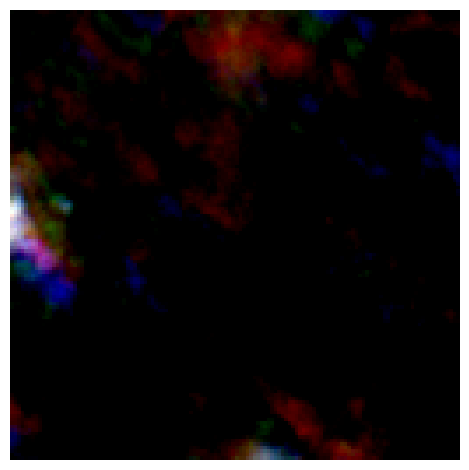

In [45]:
b = 0
img = x.permute(0,2,1,3,4)
img = get_rgb(img, b, t_show=42)
label = y[b].cpu().numpy()

# plt.imshow(label, cmap=cmap)
plt.imshow(img)

plt.axis("off")
plt.tight_layout()
plt.show()

In [32]:
x.shape

torch.Size([3, 10, 61, 128, 128])